## EDA

This notebook accomplishes the following:
* Evaluates pairwise relationships between all features
* Investigates the features within macro and equity styles categories

In [2]:
import numpy as np
import pandas as pd
import openpyxl
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# load dataframes from pickle file
with open('data_clean.pkl', 'rb') as f:
    saved = pickle.load(f)
    price_df = saved['price_df']
    return_df = saved['return_df']
    category_map = saved['category_mapping']


# Notes

### Initial Idea
✅ You're asking both—just from different angles.
✨ Main Question (Regime Modeling):
Can we find distinct periods where assets move in different patterns from each other, and from usual behavior?

We do this by:

Looking at a multivariate snapshot of returns on each day (e.g., returns of 16 assets on Day t)
Using unsupervised learning (like GMM) to group similar snapshots into clusters
Interpreting those clusters as market regimes

🧠 Think of It Like This:
Each cluster (or regime) represents a period of time where:
Some assets have consistently high returns
Others have consistently low returns
Their behavior differs significantly from other clusters

📊 What does the GMM actually do?
Each GMM cluster:

Is defined by mean return (μ) for each asset
And a covariance matrix (how assets move together)
So you’re not just grouping days by one asset going up/down—you’re clustering based on patterns of co-movement across all assets at once.



### Breakdown of dataframes

🏷️ price_df — Raw Prices
This DataFrame contains the actual index prices or levels for each asset class on a given date.
Each row is one day; each column is one asset.
👉 These are not comparable across assets (e.g., gold might be $1,800, while the equity index is 2,000)
👉 But they do give us trend direction, which we use to compute returns.

📈 return_df — Log Returns
This DataFrame contains the natural log of daily returns
👉 These are percent-like changes, but in log form
👉 These are stationary, meaning they have constant statistical properties over time (more suitable for ML)
👉 These are comparable across assets, since they represent the same concept (daily relative movement)

Imagine you’re watching several stock prices over time:

price_df tells you the stock prices each day (e.g., Apple is $172, Tesla is $700).

return_df tells you how much each one changed that day, in a normalized way (e.g., “Apple went up 1%, Tesla dropped 0.5%”).

🔁 What you’re analyzing:
Each column in return_df is a single asset class or index—like:

📈 equity → MSCI World (global stocks)

🇺🇸 us_equity → S&P 1500 (U.S. stocks)

💵 us_dollar → U.S. dollar vs global currencies

🪙 bitcoin → Cryptocurrency returns

📊 value, momentum, etc. → Style factors (smart beta)

🛢️ commodities → Oil, metals, agriculture bundle

📉 interest_rate → Long-term treasuries

🌍 em_equity → Emerging market equities

🔍 The big idea (Regime Modeling):
Can we detect hidden “market moods” or patterns in how these move together?

For example:

In a crisis, equities drop 📉, bonds rise 📈, volatility spikes ⚠️

In an expansion, equities rally 📈, credit improves, dollar weakens

In inflation, commodities soar, treasuries tank, gold outperforms

In a fragile recovery, you might see conflicting or noisy behavior

You're using unsupervised ML (like GMMs) to say:

"Hey model—look at these 16-dimensional return vectors day by day. Can you find clusters of days that look similar?"

🧩 What a single row tells you:
Each row = one trading day
Each cell = how much that asset moved (log return)
Each row vector = snapshot of global financial behavior that day

You’re clustering those vectors to find:

“Days like this behave like X regime”

“This new day feels like past 'Crisis' periods”

🔗 So yes:
You're essentially doing a market pattern detection project—finding relationships, co-movements, and clusters of behavior across assets.

You’ve just described your project perfectly in a sentence:

"Are there patterns in how these assets move—together or separately—that correspond to underlying market regimes?"



✅ What are value, momentum, quality?
These are equity style factors—systematic strategies or “themes” investors use to group stocks and build portfolios. Each one is a column in your data that tracks the performance of that strategy over time.

Think of them like different “filters” for picking stocks:

🏷️ us_equity
Benchmark: Total US stock market (S&P Composite 1500)

Broad exposure to large, mid, and small-cap U.S. companies

📉 value
Buys cheap stocks (low price-to-book, price-to-earnings)

Based on the idea that undervalued companies will rebound

Example: buying beaten-down energy companies after a slump

✅ Goes up when cheap stocks do well relative to the market
❌ Can underperform in fast tech-led rallies (where expensive stocks lead)

🚀 momentum
Buys recent winners, avoids laggards

“What’s hot stays hot” strategy

Example: If semiconductors surged last 6 months, momentum will own them

✅ Goes up when strong trends continue
❌ Can reverse sharply in regime changes (e.g., post-crisis rebounds)

🏅 quality
Picks stocks with strong balance sheets, high return on equity, low debt

Think of companies that are financially healthy

✅ Performs well in downturns or uncertain periods
❌ May lag during speculative bubbles

📊 Are they columns in your dataset?
Yes! Each one is a return series for a long/short strategy built on that factor.

If value goes up, value stocks outperformed growth stocks that day

If momentum drops, momentum stocks underperformed



## Data Dictionary

## Overview
This dataset contains daily returns for various financial indices and asset classes from S&P Global and MSCI, covering the period starting from 2016-01-11. All values represent **log returns** (natural logarithm of price ratios).

## Asset Class Categories

### Core Macro Assets
These are fundamental asset classes that form the backbone of global financial markets:

- **`commodities`** - S&P GSCI Total Return Index
  - *Description*: Broad commodity index tracking energy, agriculture, metals, and livestock futures
  - *Use*: Inflation hedge, diversification, exposure to real assets

- **`credit`** - S&P U.S. High Yield Corporate Bond Index
  - *Description*: High-yield (junk) corporate bonds with lower credit ratings
  - *Use*: Higher yield potential, credit risk exposure

- **`interest_rate`** - S&P U.S. Treasury Bond 10+ Year Index
  - *Description*: Long-term U.S. government bonds (10+ years maturity)
  - *Use*: Interest rate sensitivity, flight-to-quality asset

- **`equity`** - MSCI World Index
  - *Description*: Global developed market equities
  - *Use*: Core equity exposure, international diversification

### Secondary Macro Assets
Additional macro-level exposures that complement core positions:

- **`us_dollar`** - S&P US Dollar Futures Index Total Return
  - *Description*: U.S. dollar strength against major currencies
  - *Use*: Currency exposure, safe haven during market stress

- **`us_equity`** - S&P Composite 1500 Total Return
  - *Description*: Broad U.S. equity market (large, mid, and small cap)
  - *Use*: Core U.S. equity exposure

- **`inflation`** - S&P GSCI (U.S. 10Y TIPS) Total Return
  - *Description*: Treasury Inflation-Protected Securities
  - *Use*: Inflation protection, real return exposure

- **`bitcoin`** - S&P Bitcoin Index (USD)
  - *Description*: Cryptocurrency exposure
  - *Use*: Alternative asset, potential hedge against traditional markets

- **`em_equity`** - MSCI Emerging Markets Index
  - *Description*: Emerging market equities
  - *Use*: Higher growth potential, additional diversification

### Macro Style Factors
Systematic trading strategies based on macroeconomic themes:

- **`trend`** - S&P Equity Trend (5 Region) Long/Short Index
  - *Description*: Momentum-based strategy across global equity regions
  - *Use*: Trend following, systematic alpha generation

- **`long_vol`** - Cboe S&P 500 Constituent Volatility Index
  - *Description*: Volatility exposure based on S&P 500 components
  - *Use*: Volatility trading, risk management

### Equity Style Factors
Systematic equity strategies based on specific characteristics:

- **`value`** - S&P 500 Value Total Return
  - *Description*: Stocks with low price-to-book ratios
  - *Use*: Value investing, contrarian strategy

- **`small_cap`** - S&P 600 Total Return
  - *Description*: Small-capitalization U.S. stocks
  - *Use*: Size premium, higher growth potential

- **`low_vol`** - S&P 500 Low Volatility Index Total Return
  - *Description*: Low volatility stocks from S&P 500
  - *Use*: Defensive equity, risk reduction

- **`momentum`** - S&P 500 Momentum Index (US Dollar) Gross Total Return
  - *Description*: Stocks with strong recent performance
  - *Use*: Momentum investing, trend continuation

- **`quality`** - S&P 500 Quality (US Dollar) Gross Total Return
  - *Description*: High-quality stocks based on profitability and financial strength
  - *Use*: Quality investing, fundamental strength

## Data Characteristics

### Time Period
- **Start Date**: 2016-01-11
- **Frequency**: Daily
- **Data Type**: Log returns (natural logarithm of price ratios)

### Data Quality
- **Holiday Handling**: US exchange holidays removed
- **Missing Data**: Forward-filled (previous value carried forward)
- **Data Source**: S&P Global and MSCI indices

### Return Calculation
```python
log_return = ln(price_t / price_t-1)
```

## Usage Notes

1. **Risk Management**: Use `long_vol` and `low_vol` for risk management strategies
2. **Diversification**: Combine different asset categories for portfolio diversification
3. **Inflation Protection**: `commodities` and `inflation` (TIPS) provide inflation hedging
4. **Currency Exposure**: `us_dollar` provides currency risk management
5. **Alternative Assets**: `bitcoin` offers exposure to digital assets

## Correlation Insights
- `us_equity` and `equity` likely have high correlation (both equity markets)
- `interest_rate` and `inflation` may be inversely related
- `bitcoin` may show low correlation with traditional assets
- `trend` and `momentum` may be positively correlated

## Machine Learning Applications
This dataset is suitable for:
- Portfolio optimization
- Risk factor modeling
- Return prediction
- Asset allocation strategies
- Risk management systems 

# Jenny's Code

In [5]:
# if plotting everythign at once:

# # define the target categories
# target_cat = {"macro_styles", "equity_styles"}

# # create list of col names in target categories
# col_in_categories = []
# for cat in target_cat:
#     feature_list = category_map.get(cat)
#     for item in feature_list:
#         col_in_categories.append(item)

# # plot only features of interest
# for col in col_in_categories:
#     if col in return_df.columns:
#         sns.histplot(return_df[col], kde=True)
#         plt.title(f"Distribution of {col}")
#         plt.tight_layout()
#         plt.show()


Macro Styles Features:


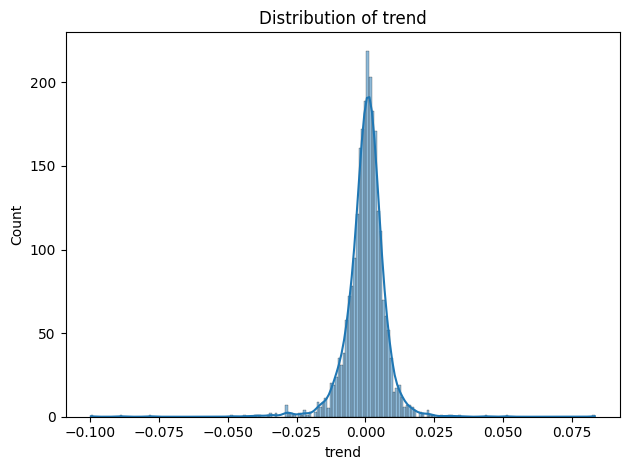

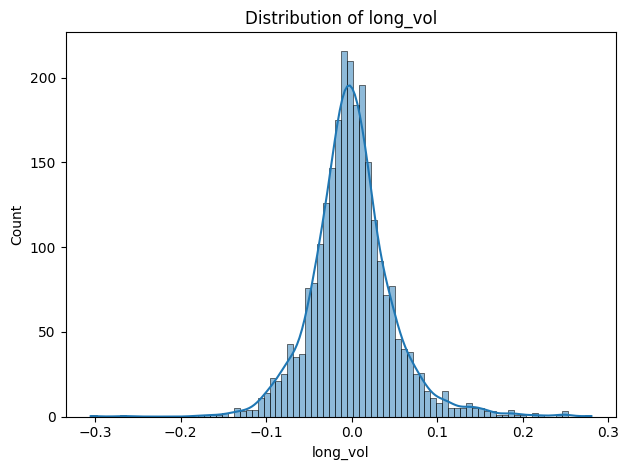

--------------------------------------------------------------------------------
Equity Styles Features:


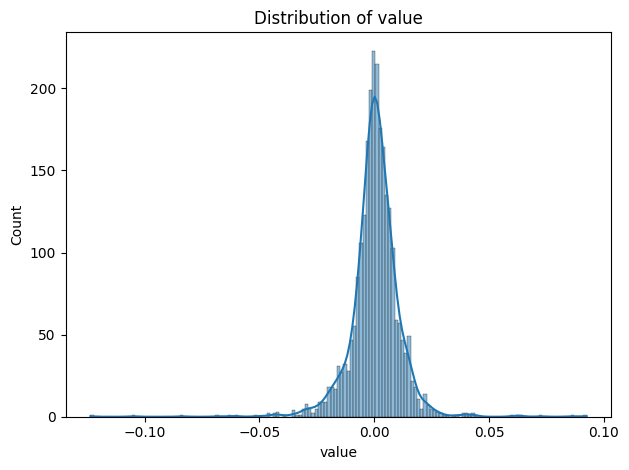

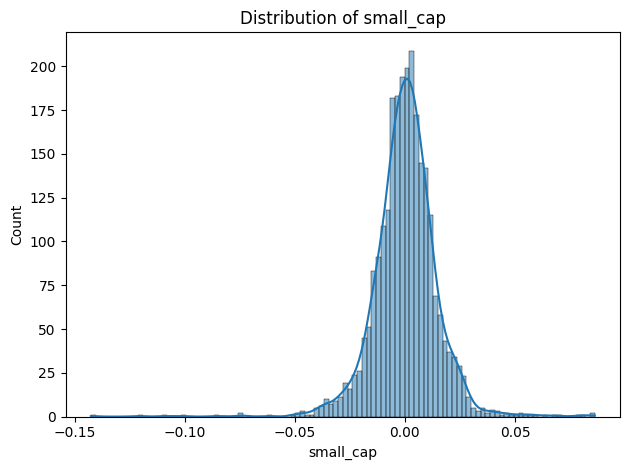

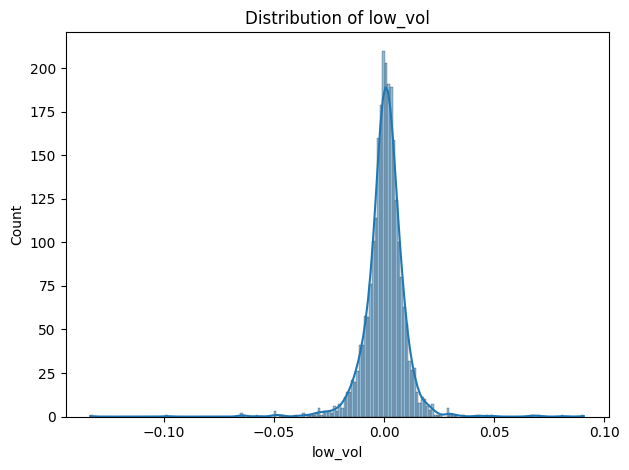

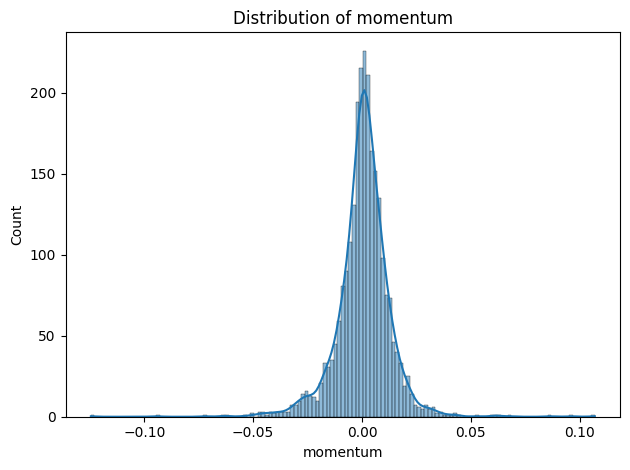

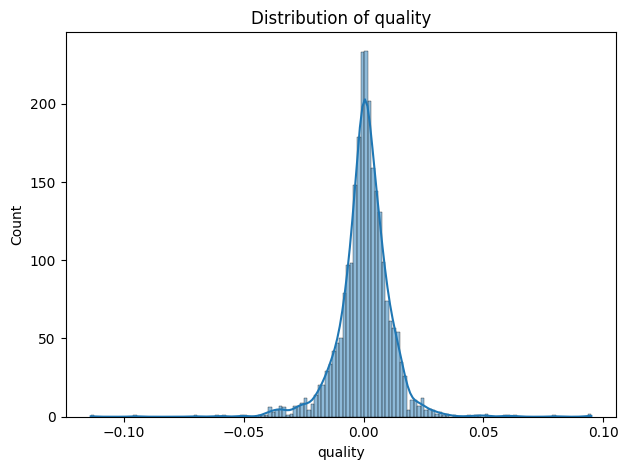

In [6]:
## Histogram of features

print("Macro Styles Features:")

# Macro_style Features
# get list of features in category
macro_styles_feats = []
for item in category_map.get("macro_styles"):
        macro_styles_feats.append(item)

# plot features in category
for feat in macro_styles_feats:
    if feat in return_df.columns:
        sns.histplot(return_df[feat], kde=True)
        plt.title(f"Distribution of {feat}")
        plt.tight_layout()
        plt.show()

print('-' * 80)
print("Equity Styles Features:")

# Equity_style Features
# get list of features in category
equity_styles_feats = []
for item in category_map.get("equity_styles"):
        equity_styles_feats.append(item)

# plot features in category
for feat in equity_styles_feats:
    if feat in return_df.columns:
        sns.histplot(return_df[feat], kde=True)
        plt.title(f"Distribution of {feat}")
        plt.tight_layout()
        plt.show()

Enter commentary about data above

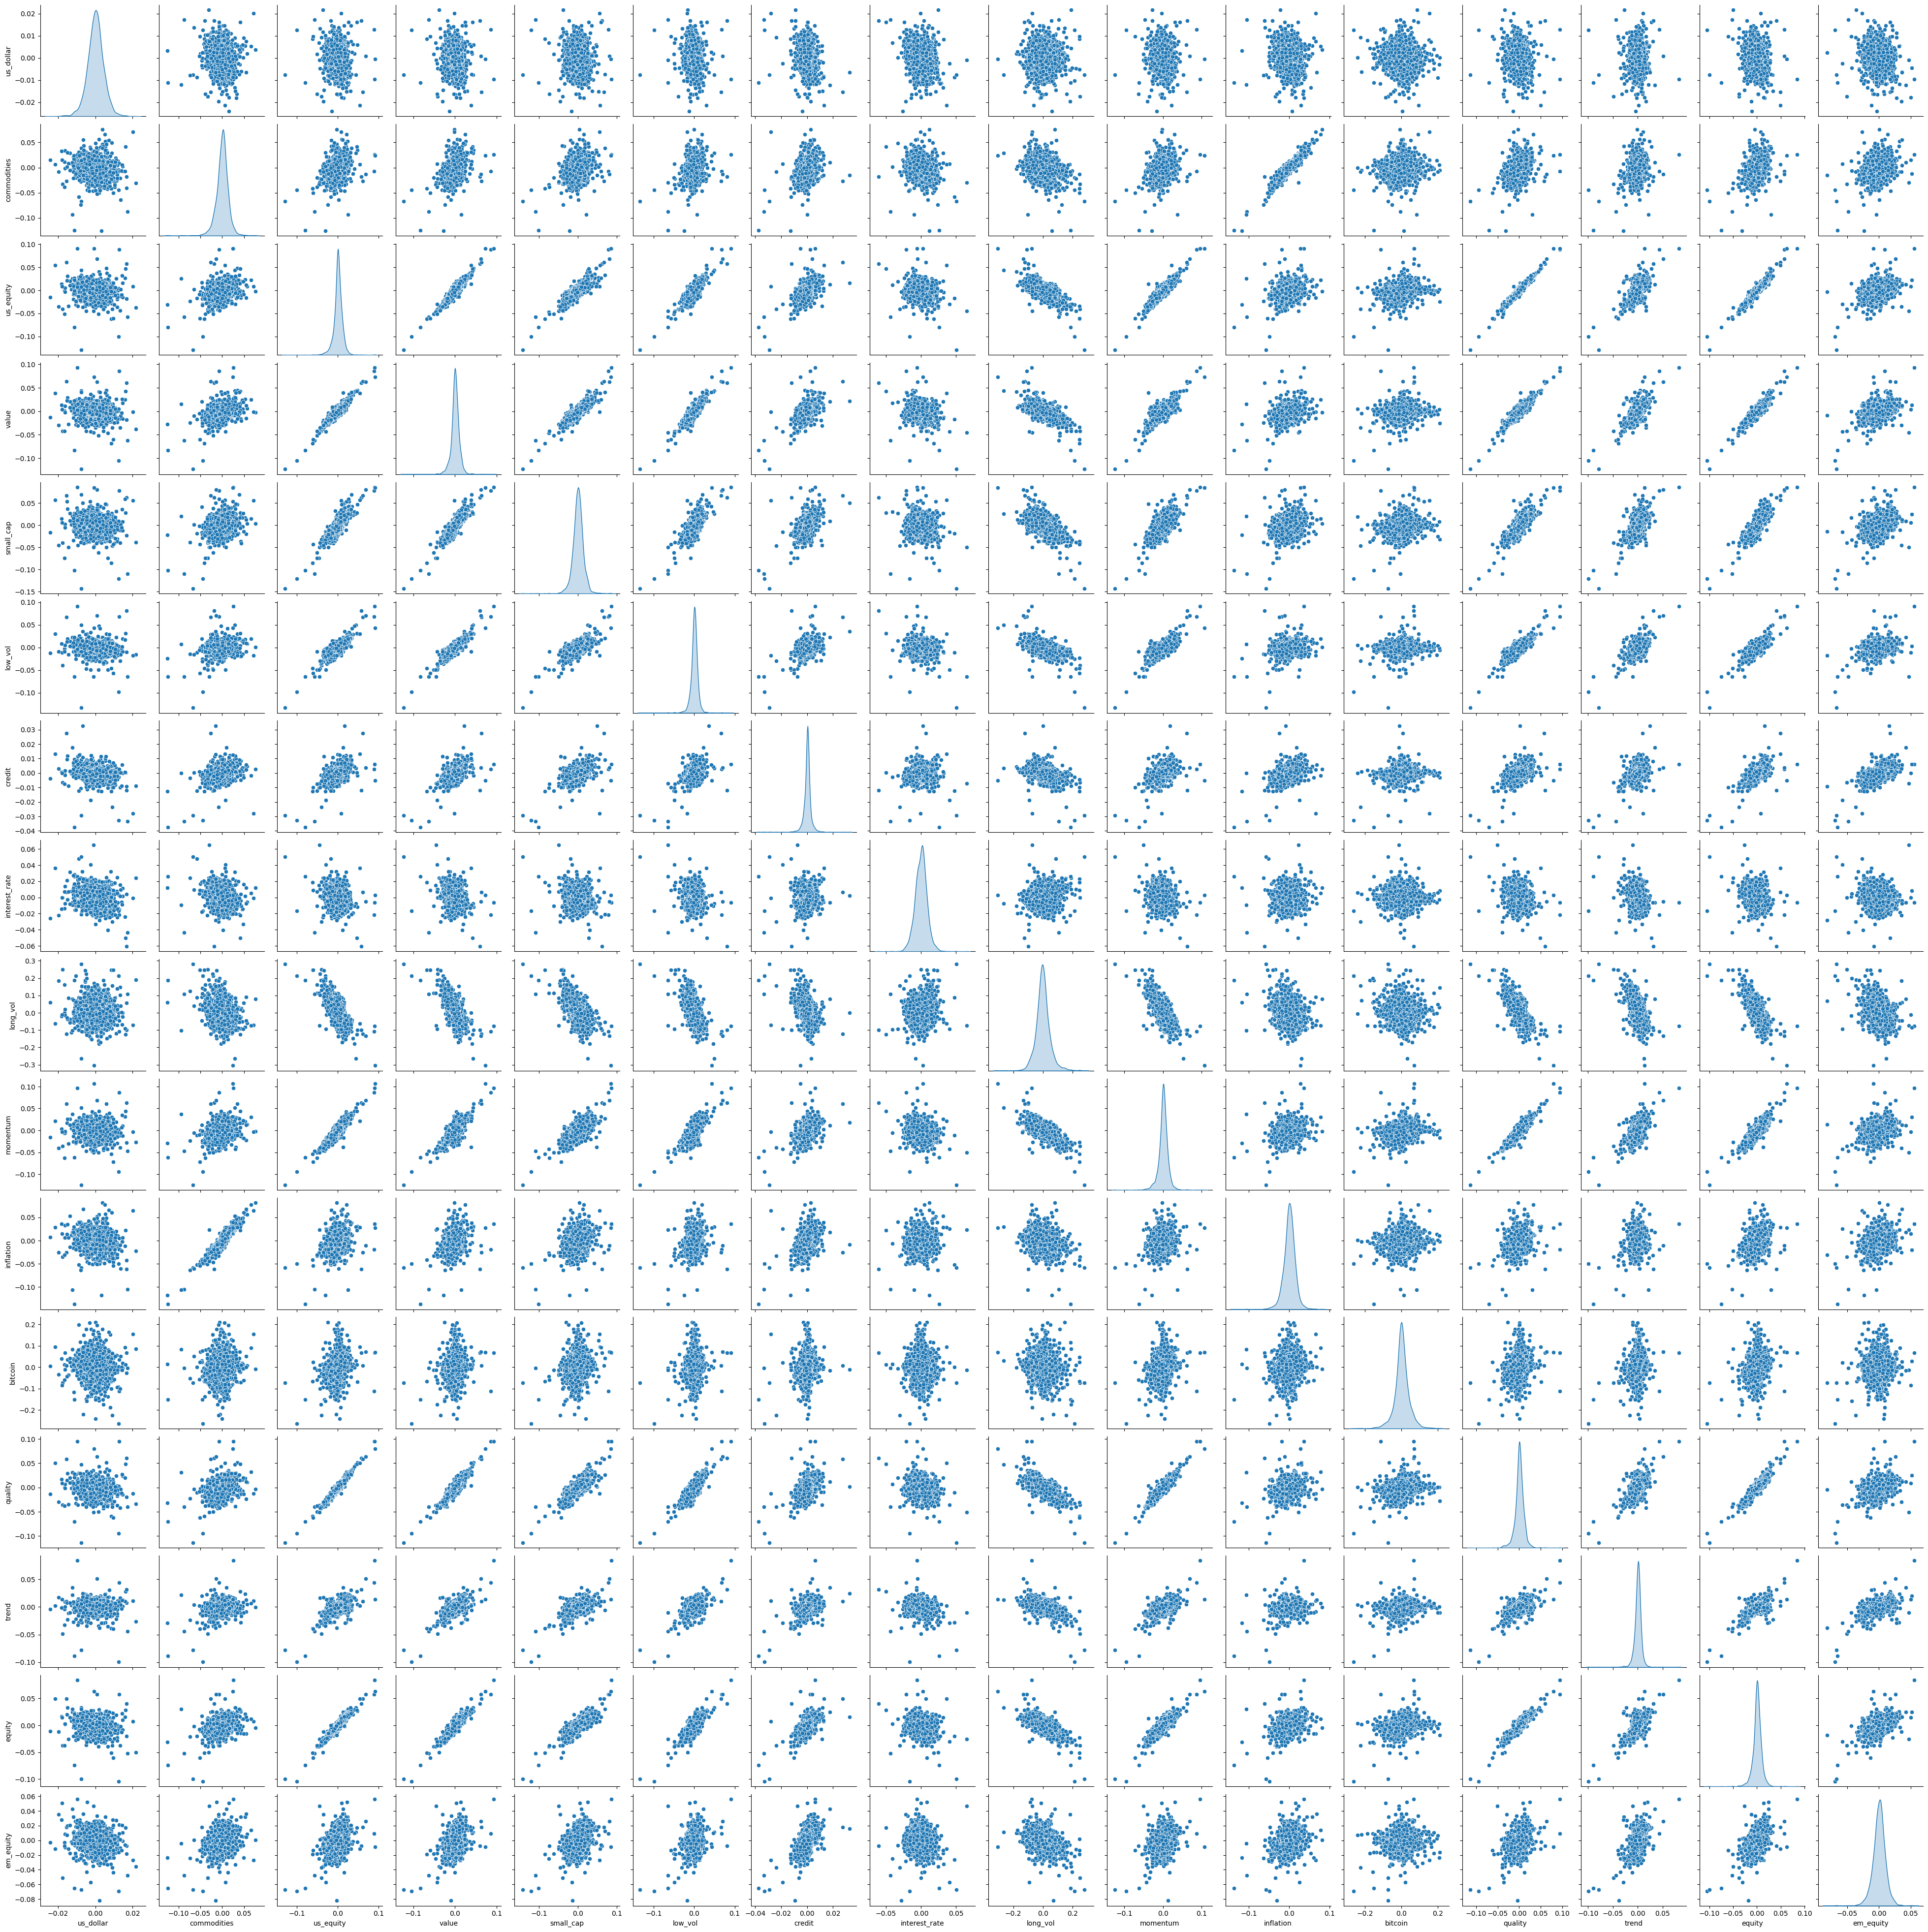

In [7]:
sns.pairplot(return_df, diag_kind='kde')

# Ryan's Code

I think one of the key questions we’re trying to answer through the EDA is whether all 16 features are necessary as inputs? So any metrics that support dimensionality reduction would be helpful!

I checked for autocorrelation in each asset and found that there are a few show significant autocorrelation (meaning for those assets the returns at t is often correlated with their returns at t-1), particularly the equity ones and credit. Since GMM assumes the observations are independent, autocorrelation may violate the assumption. We can address this by applying transformations (such as differencing) to remove autocorrelation. I was planning to cover this in `data processing` but i also noticed the instructions suggest commenting on time-based patterns in the EDA section. Feel free to use the following code to plot autocorrelation if you are going to comment on that in EDA

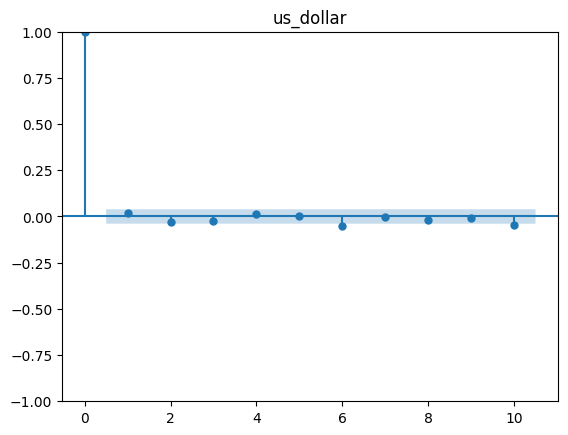

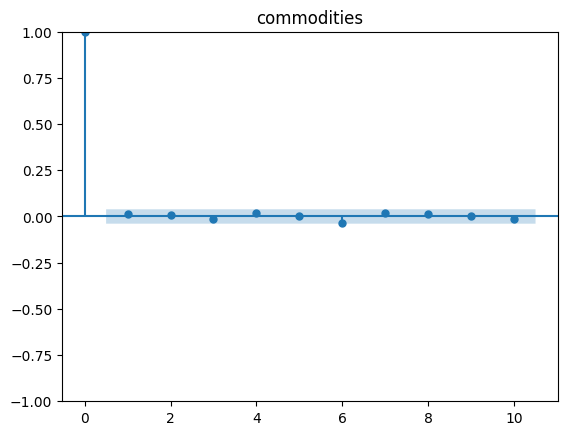

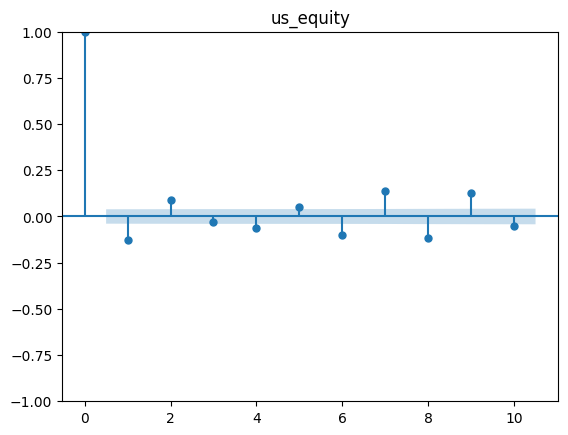

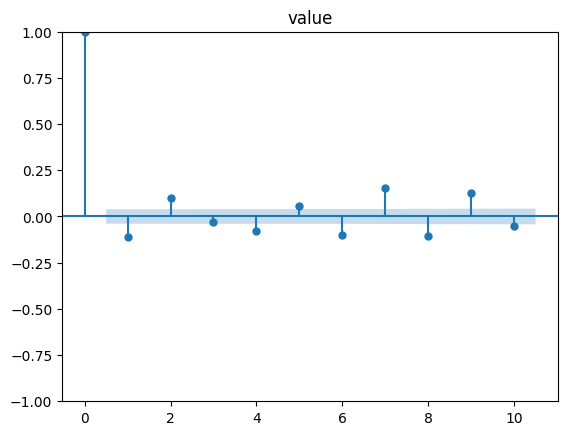

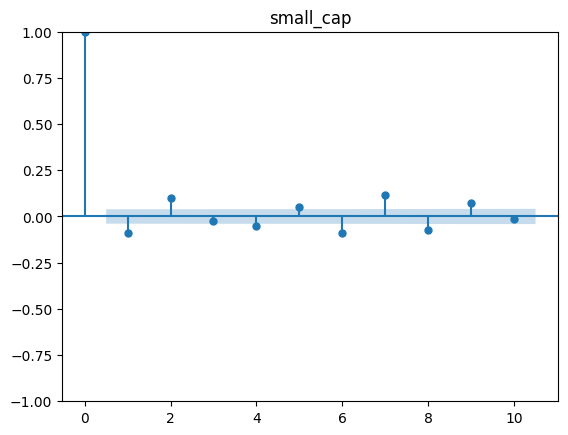

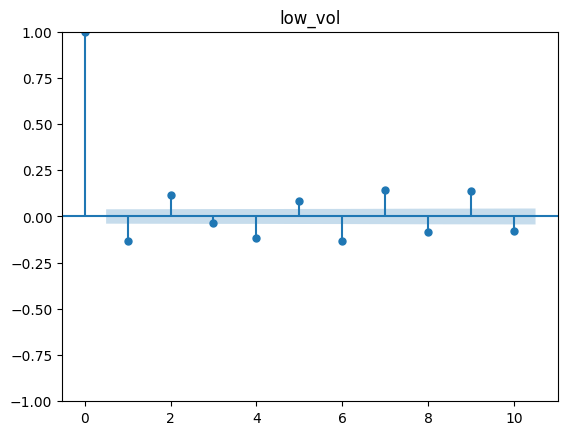

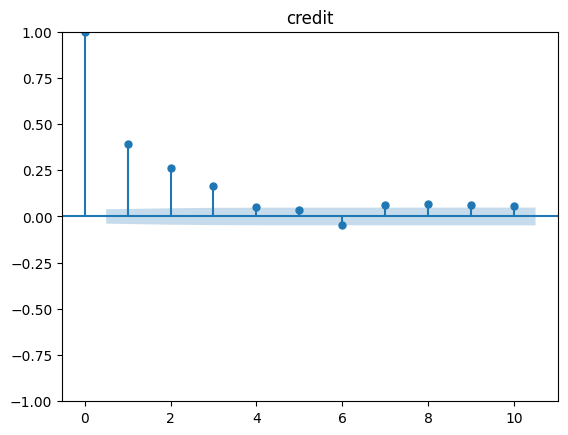

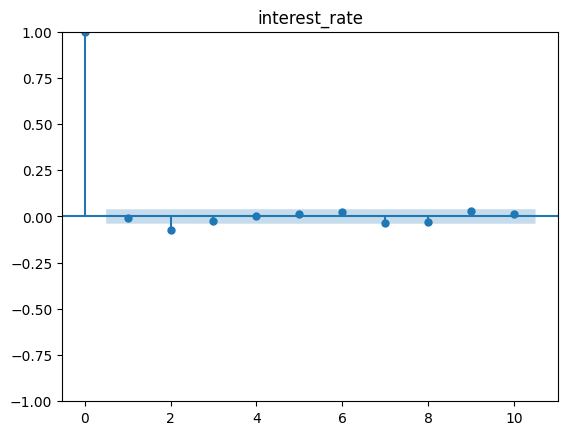

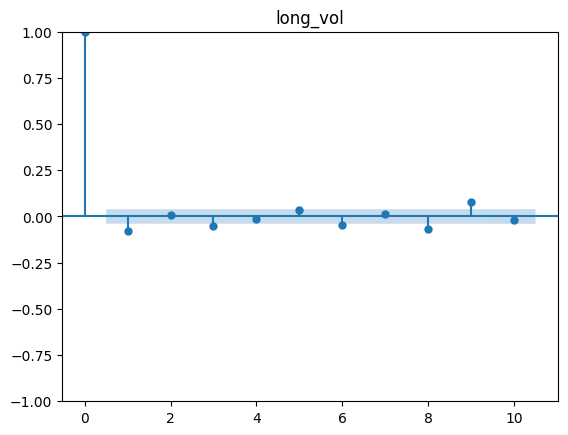

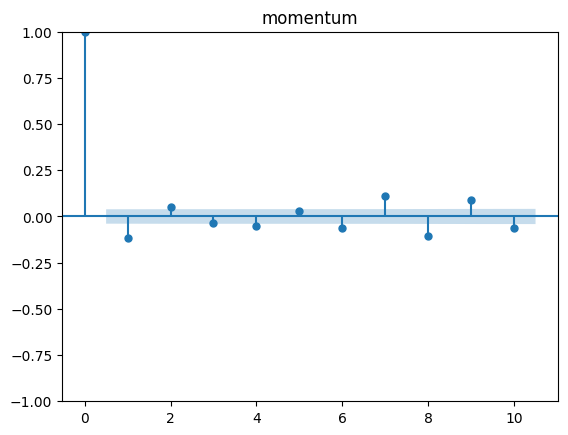

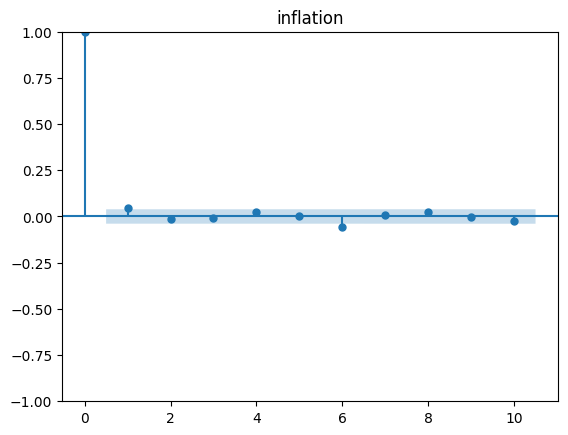

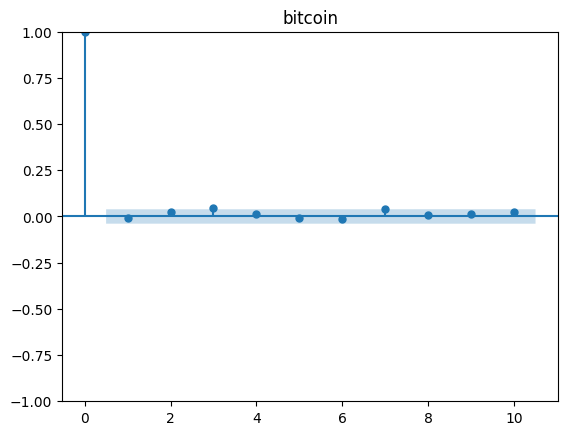

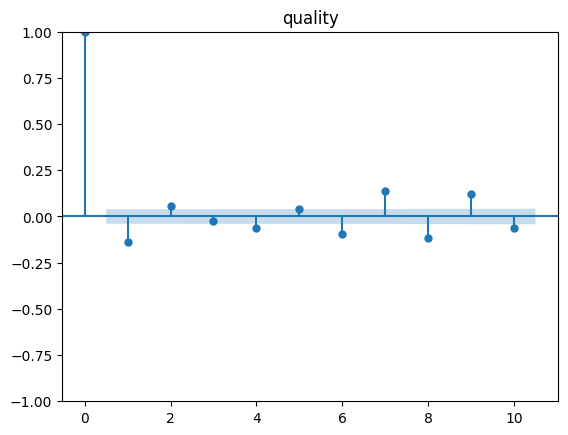

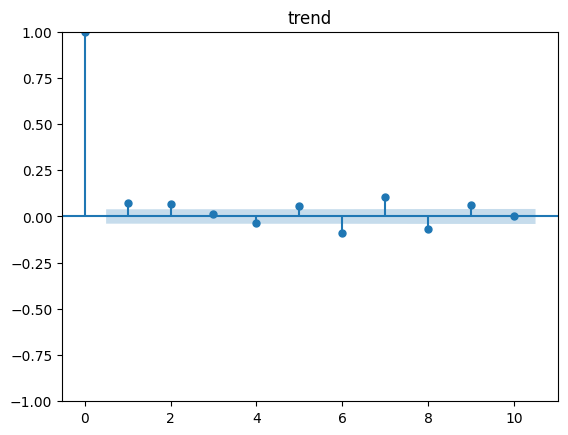

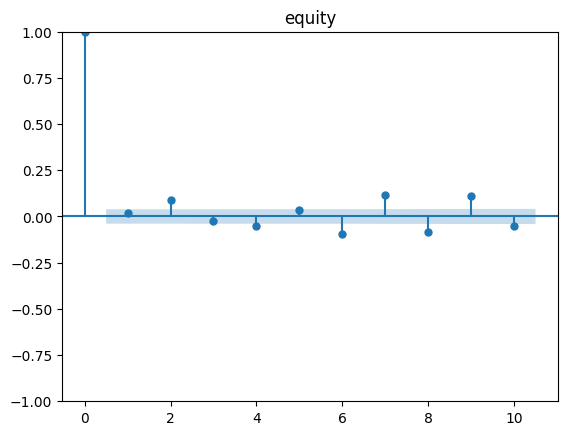

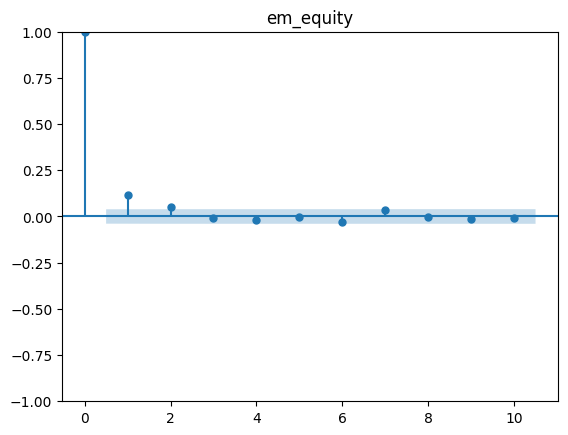

In [6]:
from statsmodels.graphics.tsaplots import plot_acf
for col in return_df.columns:
    plot_acf(return_df[col], lags=10)
    plt.title(f"{col}")
    plt.show()

In [8]:
category_map

{'core_macro': ['commodities', 'credit', 'interest_rate', 'equity'],
 'secondary_macro': ['us_dollar',
  'us_equity',
  'inflation',
  'bitcoin',
  'em_equity'],
 'macro_styles': ['trend', 'long_vol'],
 'equity_styles': ['value', 'small_cap', 'low_vol', 'momentum', 'quality']}

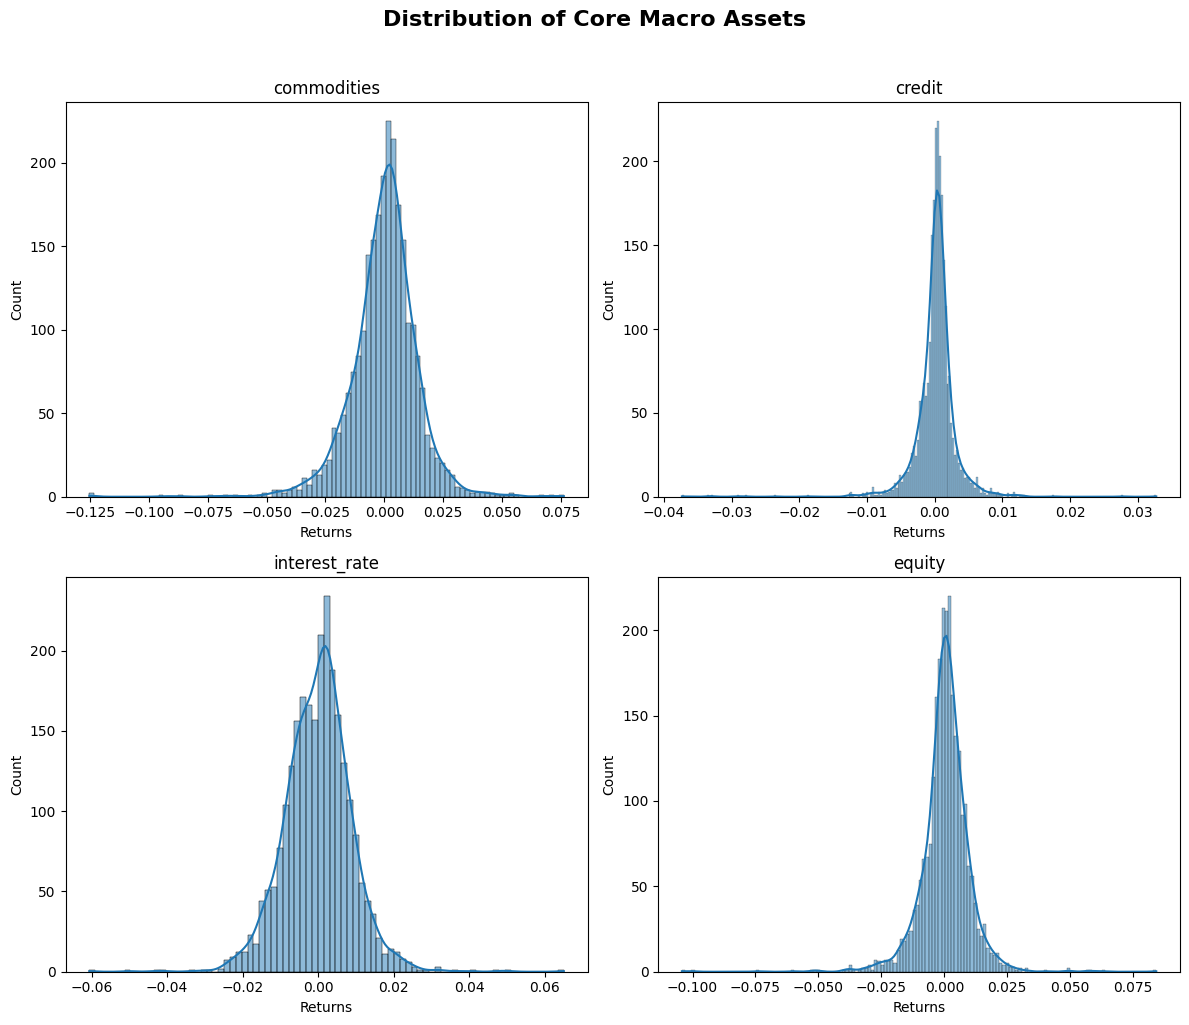

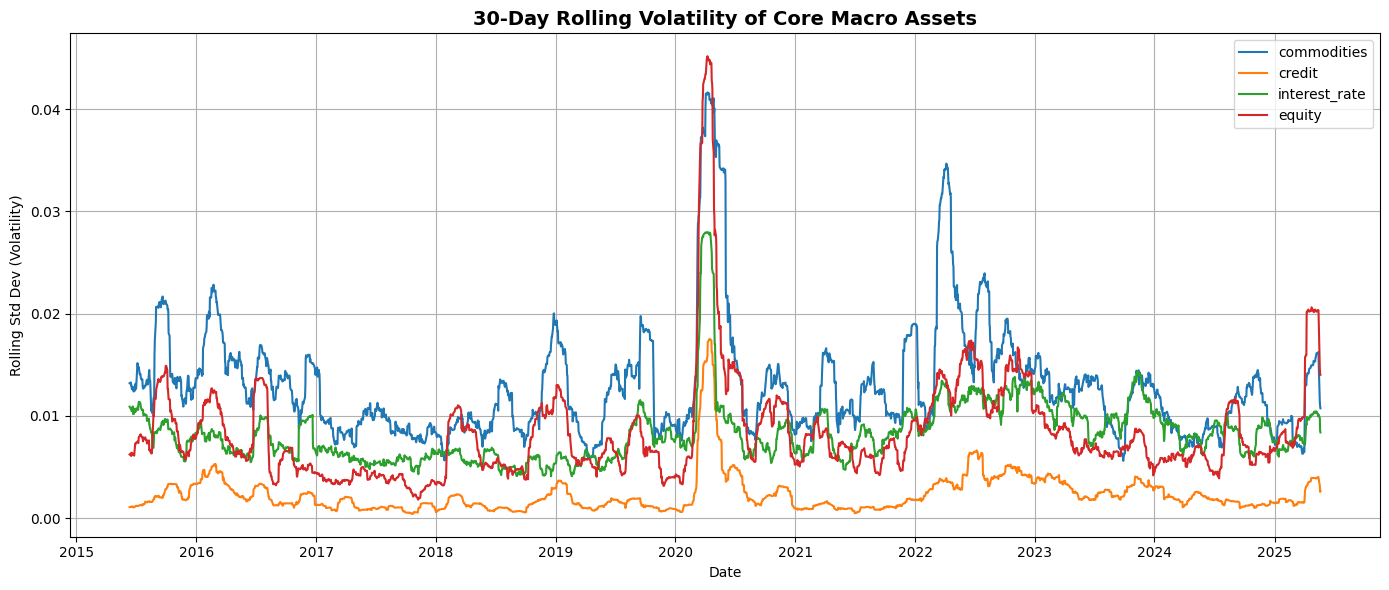

In [15]:
# Select the specified columns
columns_of_interest = ['commodities', 'credit', 'interest_rate', 'equity']
data_subset = return_df[columns_of_interest]

# Create histplot with KDE for each column# Select the specified columns
columns_of_interest = ['commodities', 'credit', 'interest_rate', 'equity']
data_subset = return_df[columns_of_interest]

# --- HISTOGRAMS (Your original code) ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, col in enumerate(columns_of_interest):
    sns.histplot(data_subset[col], kde=True, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('Returns')

plt.suptitle('Distribution of Core Macro Assets', y=1.02, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# --- ROLLING VOLATILITY ---
rolling_vol = data_subset.rolling(window=30).std()

plt.figure(figsize=(14, 6))
for col in columns_of_interest:
    plt.plot(rolling_vol.index, rolling_vol[col], label=col)

plt.title('30-Day Rolling Volatility of Core Macro Assets', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Rolling Std Dev (Volatility)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

📈 Rolling Volatility Analysis: Core Macro Assets
To assess the temporal dynamics of risk across key asset classes, we plotted the 30-day rolling standard deviation (volatility) of daily log returns for four core macro assets: commodities, credit, interest_rate, and equity. This exploratory analysis provides insights into how the stability of asset returns fluctuates over time, highlighting potential market regime shifts.

🔍 Key Observations
Credit Exhibits the Lowest and Most Stable Volatility

The credit asset class shows consistently low volatility throughout the observed period.

This suggests that U.S. high-yield corporate bonds, despite being riskier than Treasuries, exhibit more muted daily fluctuations compared to other asset classes in this dataset.

In a regime modeling context, credit may serve as a relatively stable reference, helping differentiate high-volatility regimes (e.g., crisis) from steady ones.

Commodities Show the Highest and Most Variable Volatility

commodities display frequent and substantial volatility spikes, especially around major macroeconomic events.

Notably, volatility surged in:

Early 2020 (COVID-19 crash)

2022 (likely due to inflation shocks and the Russia–Ukraine conflict)

This pronounced and episodic volatility makes commodities a key signal for identifying unique regimes such as inflation shocks or supply chain crises.

COVID-19 Crisis Period (March 2020) is Clearly Detectable

All four asset classes show synchronized volatility spikes during early 2020.

This aligns with the well-documented global market turmoil following the COVID-19 outbreak, suggesting a highly volatile, systemic “crisis regime.”

Asynchronous Spikes in 2022

Unlike the COVID crash, the 2022 volatility spike is more isolated to commodities.

Other assets, like equity and interest_rate, do not exhibit matching volatility increases.

This decoupling supports the hypothesis of a distinct market regime—possibly an “inflation regime”—which would be important for unsupervised clustering (e.g., GMM) to detect.

Periods of Calm Suggest Steady-State Regimes

Extended periods with low and stable volatility (e.g., parts of 2017 and late 2023) could correspond to steady-state market regimes.

These intervals are likely to form separate clusters in a Gaussian Mixture Model, reflecting conditions of broad market stability.

🧠 Interpretation for GMM Clustering
This volatility analysis reinforces the rationale for applying Gaussian Mixture Models. The time-varying, asset-specific volatility behavior—especially when it diverges across asset classes—provides a rich signal for clustering different market regimes.

Crisis regimes may be characterized by synchronized volatility spikes across all assets.

Inflation or commodity-led regimes may show volatility divergence, where one asset class (e.g., commodities) behaves distinctly from the others.

Calm regimes show low and stable volatility, creating a clear contrast to crisis periods.

These dynamic patterns provide strong support for the use of time-windowed GMM clustering to uncover distinct market states based on cross-asset behavior.



All four distributions are unimodal, roughly symmetric around 0. Fat tails for commodities and interest_rate. Reasonably well behaved and suitable for GMM.

🔄 Rolling Volatility (what you just did)
❓ What it measures:
How much the asset moves up and down (i.e., the size of daily fluctuations)

It answers:

“How turbulent is this asset lately?”

📊 Calculated as:
30-day rolling standard deviation of returns

Measures risk, not direction

High volatility = larger swings (could be up or down)

📈 Time Series Trend (cumulative return)
❓ What it measures:
The direction and magnitude of performance over time

It answers:

“Has this asset generally gone up or down?”

📊 Calculated as:
Cumulative sum of daily log returns

Captures directional movement, not risk

### Cumulative Log Returns

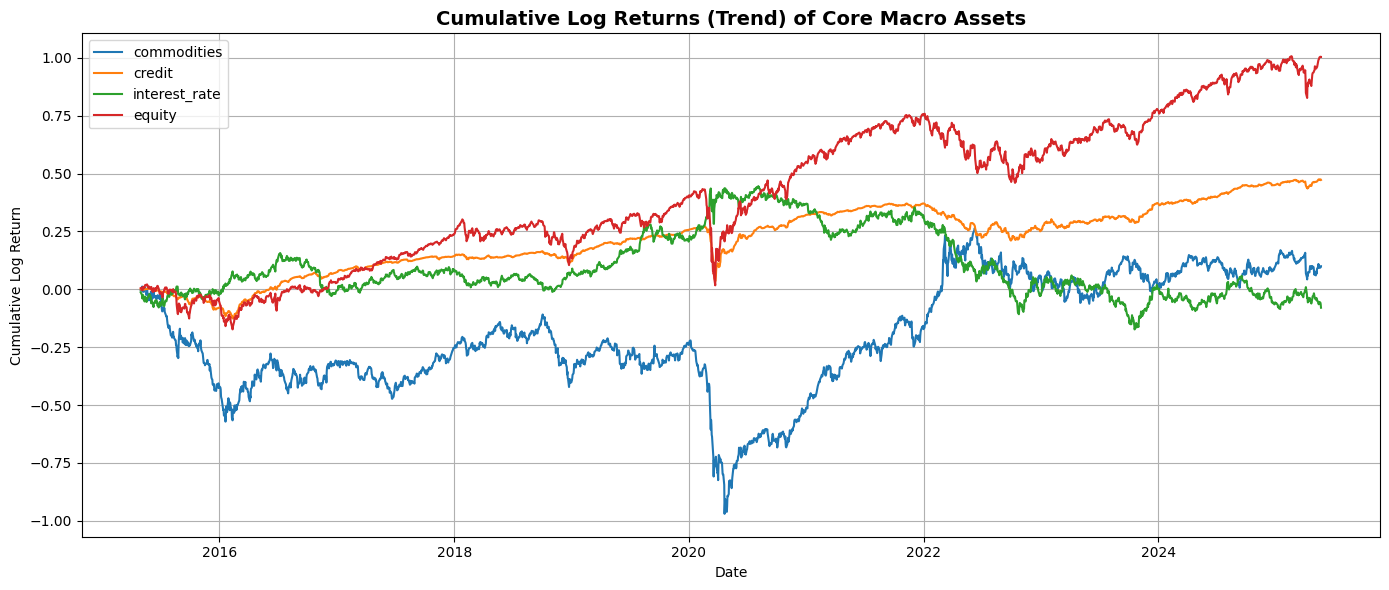

In [16]:
### Cumulative Log Returns
import matplotlib.pyplot as plt

# Select core macro asset columns
columns_of_interest = ['commodities', 'credit', 'interest_rate', 'equity']
data_subset = return_df[columns_of_interest]

# Calculate cumulative log returns (trend over time)
cumulative_returns = data_subset.cumsum()

# Plot the trends
plt.figure(figsize=(14, 6))
for col in columns_of_interest:
    plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)

plt.title('Cumulative Log Returns (Trend) of Core Macro Assets', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📈 Cumulative Log Return Analysis of Core Macro Assets
This chart shows the cumulative log returns of four key macro asset classes—equity, credit, interest rate, and commodities—from 2015 to 2025. Log returns have been summed over time, allowing us to observe the trend in performance and relative strength of each asset class across various market regimes.

🟥 Equity (Red Line)
What it measures: Broad U.S. stock market returns (e.g., S&P 500).

Trend: Strong and consistent upward trend over the 10-year period.

Interpretation: Reflects the long-term economic growth and investor optimism about corporate earnings. Notable dips during:

March 2020 (COVID crash)

2022 (inflation + rate hike fears)

Why this happens: Stocks tend to perform well in expansionary regimes due to rising profits and favorable risk sentiment.

🟧 Credit (Orange Line)
What it measures: Corporate bond performance (e.g., investment-grade debt).

Trend: Steady upward trajectory with less volatility than equities.

Interpretation: Credit markets benefit from low interest rates and economic stability. However, they are more sensitive to default risk during downturns.

Why this happens: Corporate bonds are riskier than treasuries but safer than equities. Their performance often sits “in the middle.”

🟩 Interest Rate (Green Line)
What it measures: Inverse exposure to interest rates (e.g., bond prices increase when rates fall).

Trend: Mild gains until ~2021, then a downward trend.

Interpretation: Rates were falling from 2015–2020, boosting bond prices. The sharp drop post-2021 reflects rising interest rates, which depress bond prices.

Why this happens: As central banks hiked rates to fight inflation (2022–2023), fixed income assets suffered. The reversal shows how macroeconomic policy shifts define distinct regimes.

🟦 Commodities (Blue Line)
What it measures: Broad commodity index (e.g., energy, metals, agriculture).

Trend: Significant drawdown from 2015–2020, sharp rise during COVID/post-COVID inflation, then noisy fluctuations.

Interpretation: Commodities are highly sensitive to global demand, inflation, and geopolitical shocks (e.g., oil spikes).

Why this happens:

2015–2020: Deflationary trends, weak global demand.

2021 spike: Inflation surge, supply chain disruptions.

Post-2022: Volatile but less directional.



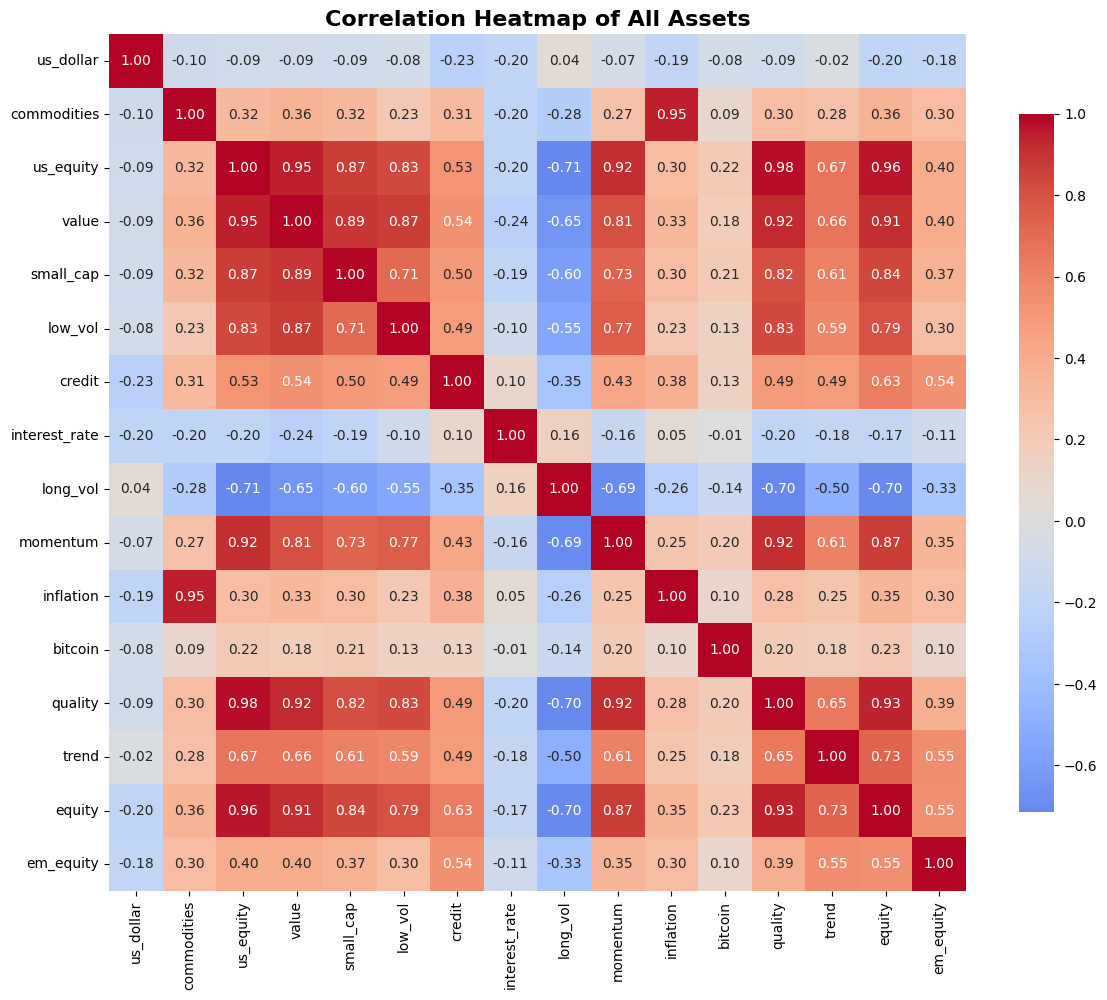

In [12]:
# Create correlation heatmap for all variables in return_df
plt.figure(figsize=(12, 10))
correlation_matrix = return_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Correlation Heatmap of All Assets', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

We computed pairwise Pearson correlations between all asset class log returns to examine potential relationships and clustering behavior.
We observe a strongly correlated equity cluster—including us_equity, value, momentum, quality, and trend—with coefficients frequently above 0.9. This suggests these factors tend to rise and fall together, particularly during periods of strong market sentiment.

Conversely, long_vol shows consistent negative correlation (≈ -0.7) with equities and credit, behaving as a downside hedge in risk-off regimes. (Long meaning you are holding the asset because you think it will go up - you are bullish. Short being the opposite where you borrow and sell something you don't own, hoping the price will fall. If it drops, you buy it back cheaper and profit.) So long volatility means you think the market will be volatile. When equities crash, volatility usually spikes. So if you're long volatility, you tend to profit when stocks drop. Think of long volatility like buying an umbrella company: On sunny days (equities up), umbrella sales are flat or fall (vol is low) On stormy days (equities crash), everyone buys umbrellas—you profit! So being long vol is like owning storm insurance.

Bitcoin displays very low correlation with all other assets, reinforcing its behavior as a potential alternative diversifier.
These relationships provide evidence that market regimes may emerge from co-movement patterns across asset groups, which our subsequent unsupervised models aim to uncover.

🤖 In Clustering (GMM, KMeans, etc.):
You do NOT need to remove highly correlated features. In fact, those relationships are the signal.

Why?
You're not modeling a response variable—you're modeling joint patterns
If two assets are 90% correlated in normal times, but decouple during crises, that difference is precisely what helps define the regimes
GMM will learn the correlation structure per cluster, not globally

📈 Concrete Example:
us_equity and quality might be +0.95 correlated overall
In most regimes, they rise/fall together
But in crises, maybe quality drops less, or even rises
That change in relationship is exactly what GMM wants to find.





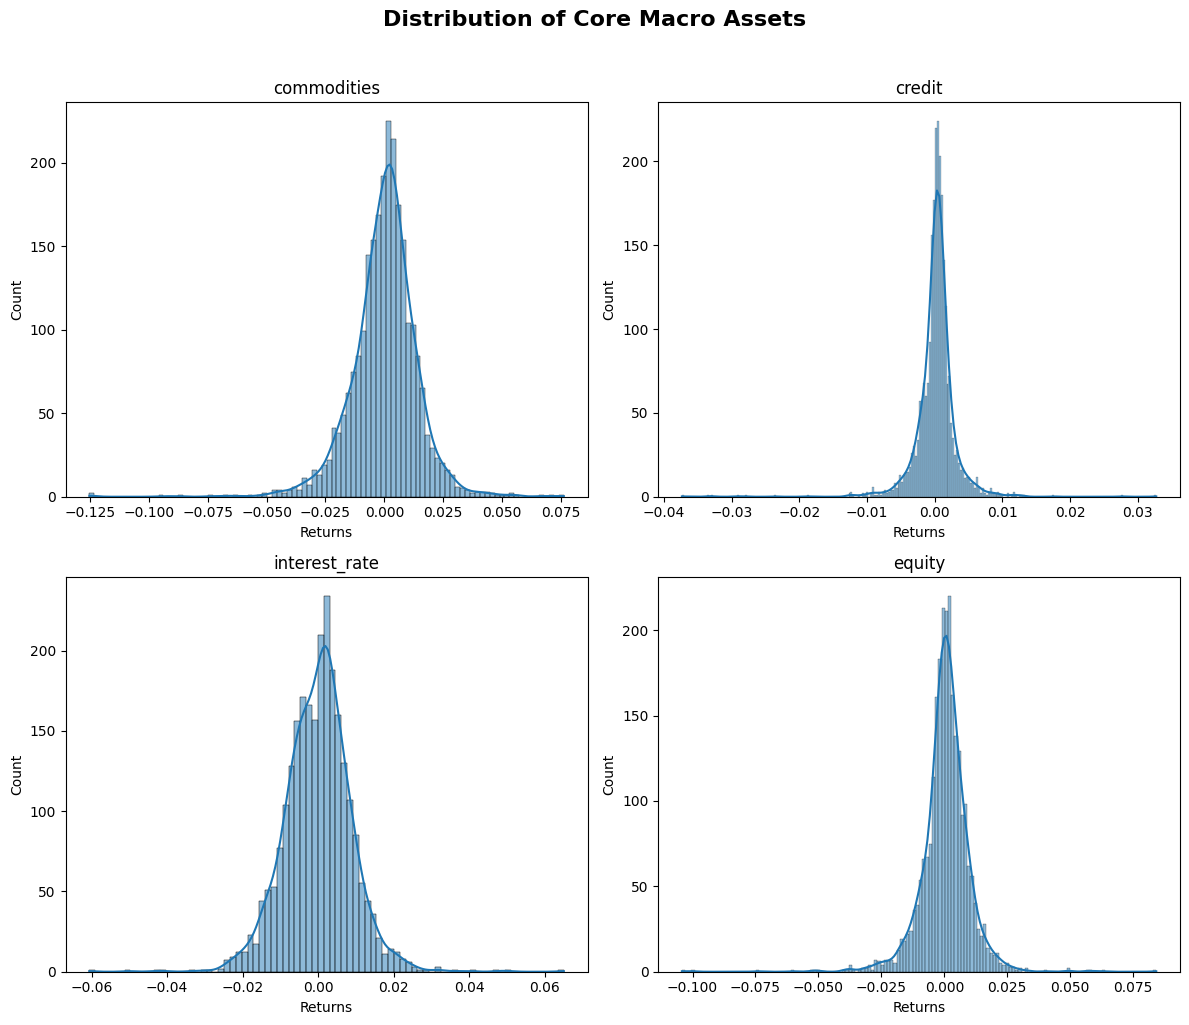

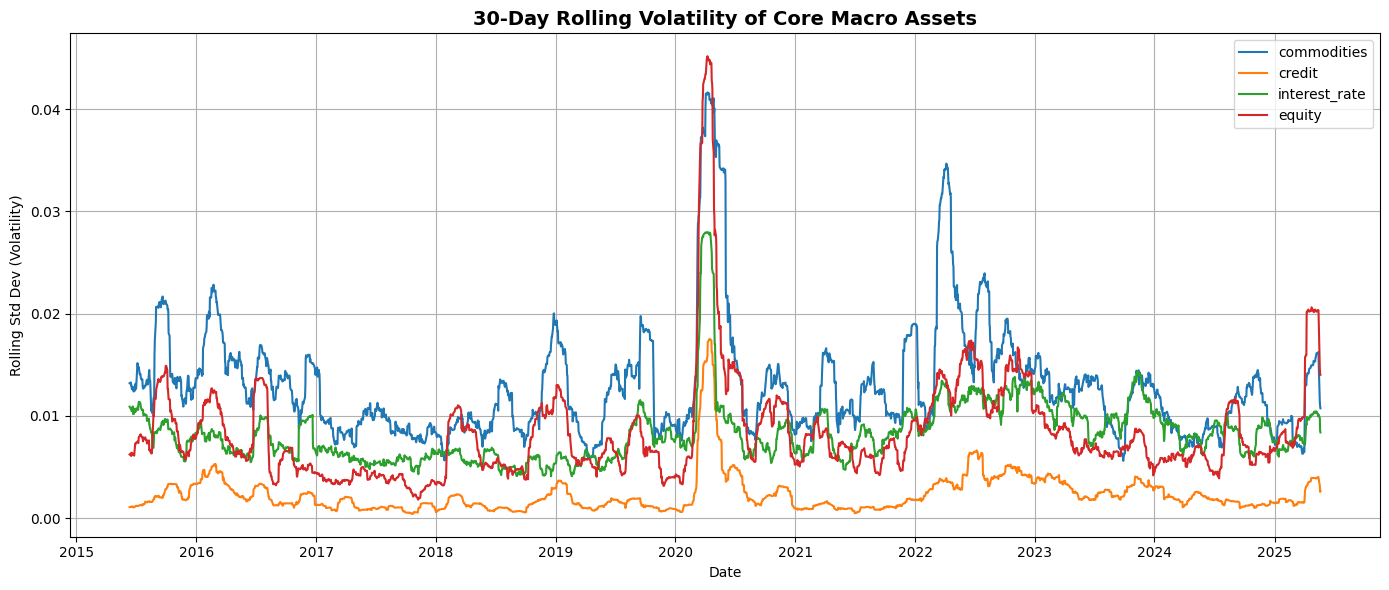

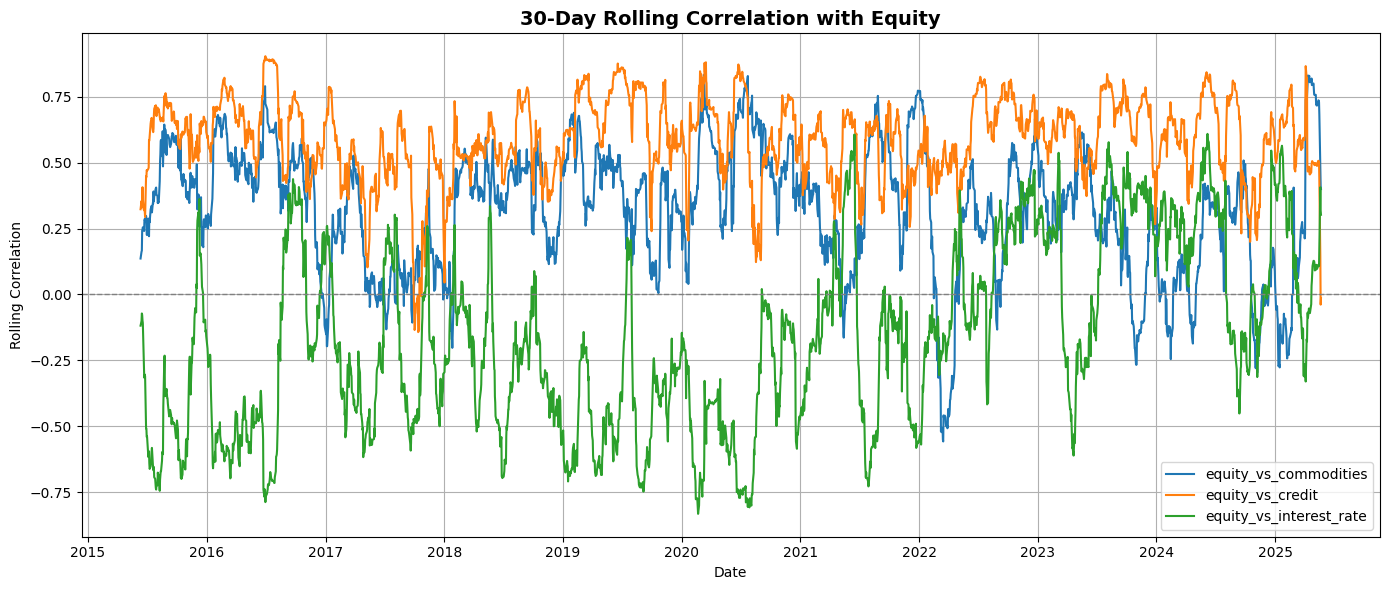

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Define your asset columns
core_assets = ['commodities', 'credit', 'interest_rate']
base_asset = 'equity'

# Compute rolling correlations (30-day window)
rolling_corr = pd.DataFrame(index=return_df.index)

for asset in core_assets:
    rolling_corr[f'{base_asset}_vs_{asset}'] = return_df[base_asset].rolling(30).corr(return_df[asset])

# Plot
plt.figure(figsize=(14, 6))
for col in rolling_corr.columns:
    plt.plot(rolling_corr.index, rolling_corr[col], label=col)

plt.title(f'30-Day Rolling Correlation with {base_asset.capitalize()}', fontsize=14, fontweight='bold')
plt.ylabel('Rolling Correlation')
plt.xlabel('Date')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


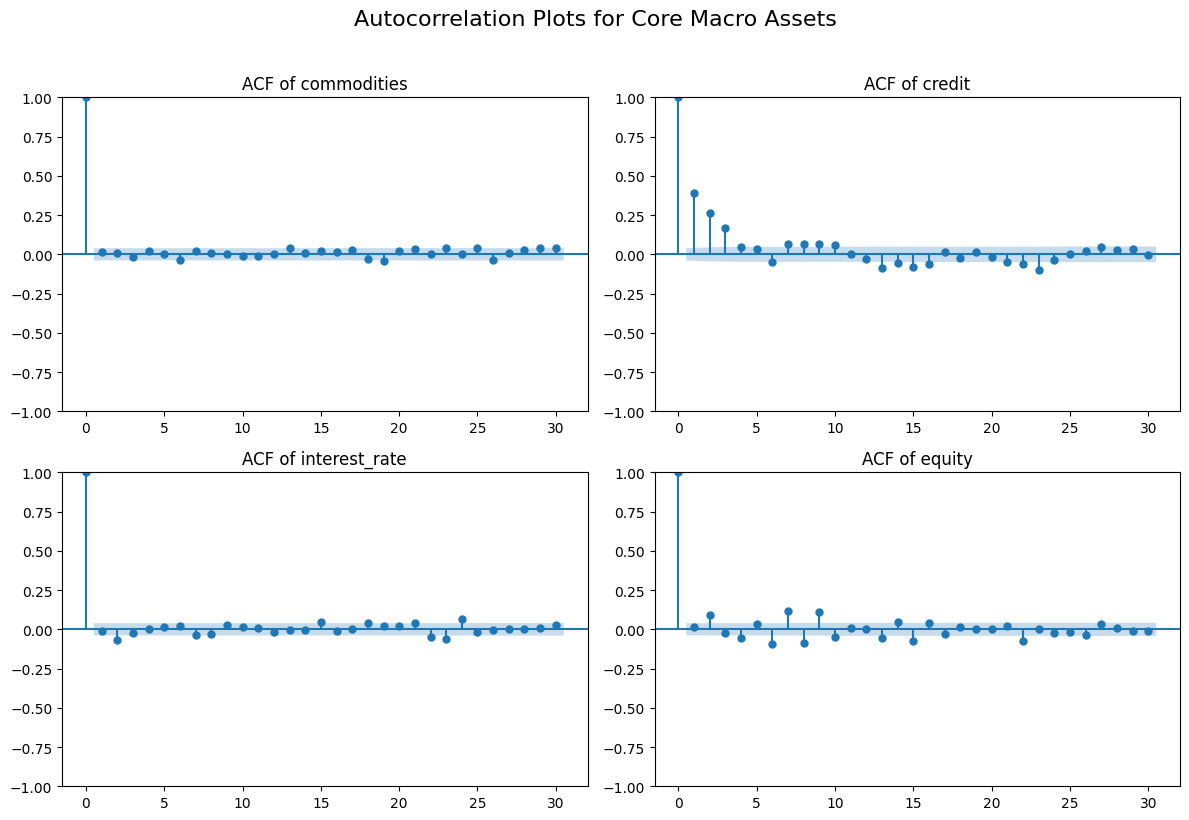

In [18]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Select the relevant columns
columns_of_interest = ['commodities', 'credit', 'interest_rate', 'equity']
data_subset = return_df[columns_of_interest]

# Create ACF plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for i, col in enumerate(columns_of_interest):
    plot_acf(data_subset[col].dropna(), ax=axes[i], lags=30)
    axes[i].set_title(f'ACF of {col}')

plt.suptitle('Autocorrelation Plots for Core Macro Assets', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Feature variances (sorted):
credit           0.000010
us_dollar        0.000020
trend            0.000060
interest_rate    0.000079
low_vol          0.000096
equity           0.000098
em_equity        0.000108
value            0.000123
quality          0.000132
us_equity        0.000136
momentum         0.000160
commodities      0.000200
small_cap        0.000215
inflation        0.000228
bitcoin          0.001738
long_vol         0.002313
dtype: float64


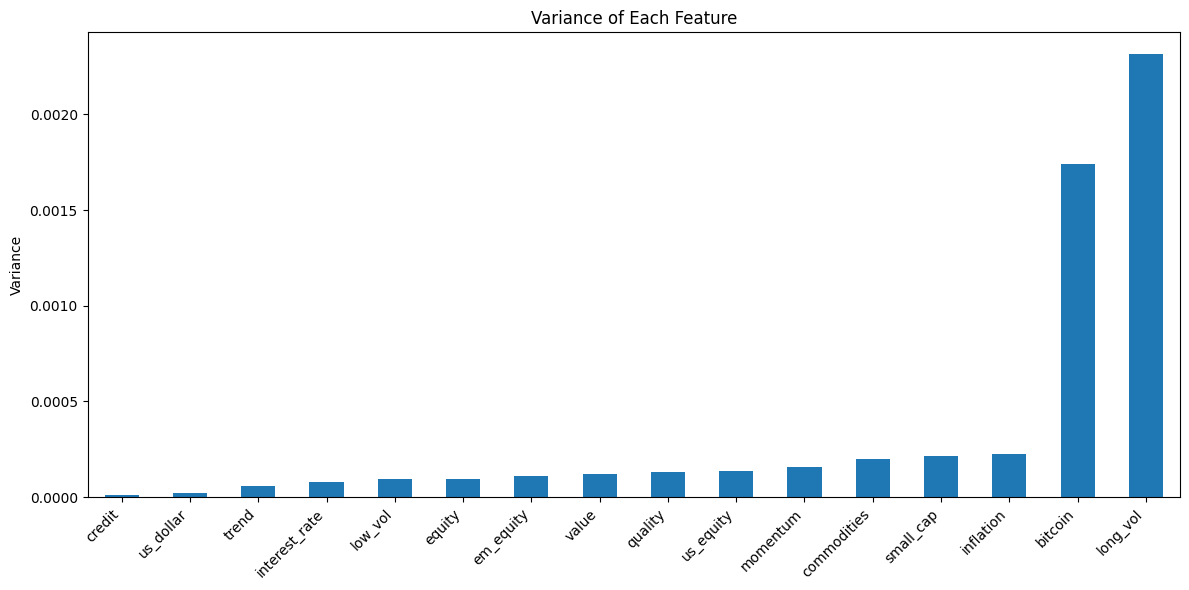

In [19]:
# Calculate variance of each feature
feature_variances = return_df.var().sort_values()

# Display variances
print("Feature variances (sorted):")
print(feature_variances)

# Optional: Visualize the variances
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
feature_variances.plot(kind='bar')
plt.title('Variance of Each Feature')
plt.ylabel('Variance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
